# Baseline Model Extension: Random Forest
In my baseline model, I began with a linear regression model where I did not modify any of the features. I built the model solely with the original features to see how a model would score when considering all of the housing features. I then moved on to apply a lasso regression model to the data set, which in turn eliminated certain features from each data set that gave the models a high penalty. Now, as an extension to the baseline models I defined, I will apply an ensemble learning method: Random Forest.

Random forest regression is an ensemble of randomized decision trees. Decision trees fall victim to overfitting as a result of being trained and built on speific data. Different data can result with vastly different decision trees, which is an issue when we are trying to build a model that can generalize to data beyond the training subset. Random forest takes these decisions trees and combines them together to form one cohesive model. 

Random forest is a bagging technique. Bagging is a combination of bootstrapping and aggregation. By sampling from the population with replacement (bootstrap) and aggregating these models built on these samples together, we can avoid overfitting a model to a single subset of the data. These individual models are run independently and in parallel, and do not interact with each other. This is good to keep training completely uninfluenced by each other.

Each model is going to be built on a random tree containing a bootstrapped sample of my housing data. The predictions for the housing price of each tree will be used to aggregate the models into a single general model.

In [82]:
# Import necessary modules
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import meanabs

import math

In [2]:
# Create df on Macbook
dc_df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_2/data/dc_updated.csv")
kc_df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_2/data/kc_updated.csv")

# Create df on PC
#dc_df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_2/data/dc_updated.csv")
#kc_df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_2/data/kc_updated.csv")

# Set up 'month column' and convert categorical features to category codes
dc_df['month'] = pd.to_datetime(dc_df['date']).dt.month
kc_df['month'] = pd.to_datetime(kc_df['date']).dt.month

dc_df["condition"] = dc_df["condition"].astype('category').cat.codes
kc_df["condition"] = kc_df["condition"].astype('category').cat.codes
dc_df["grade"] = dc_df["grade"].astype('category').cat.codes
kc_df["grade"] = kc_df["grade"].astype('category').cat.codes

dc_df = dc_df.drop(columns=['Unnamed: 0', 'date', 'location'])
kc_df = kc_df.drop(columns=['Unnamed: 0', 'date', 'location'])

In [3]:
# Scale data frame data
def scale_df(df):
    """Function that scales a data frame about the mean"""
    return df.iloc[:,:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

dc_df_scaled = scale_df(dc_df)
kc_df_scaled = scale_df(kc_df)

# Building the Model

In [4]:
# Grab the original prices and features we will use to build the model
dc_prices = np.array(dc_df_scaled['price'])
kc_prices = np.array(kc_df_scaled['price'])
features = ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'yr_built', 'yr_renovated', 'month']

# Create new data frame without the price column
dc_features = dc_df_scaled[features]
kc_features = kc_df_scaled[features]

## Split data into training and test data

By using the same *random_state* parameter as my base model, I can split the data into the training and test data the same way. This keeps everything globally consistent with each other and ensures that the data I am using to build each model is consistent.

In [8]:
# Split the data into training and testing sets
dc_train_features, dc_test_features, dc_train_prices, dc_test_prices = train_test_split(dc_features, dc_prices, 
                                                                            test_size = 0.2, random_state = 42)
kc_train_features, kc_test_features, kc_train_prices, kc_test_prices = train_test_split(kc_features, kc_prices, 
                                                                            test_size = 0.2, random_state = 42)

In [6]:
print('Washington D.C. Training Features Shape:', dc_train_features.shape)
print('Washington D.C. Training Labels Shape:', dc_train_labels.shape)
print('Washington D.C. Testing Features Shape:', dc_test_features.shape)
print('Washington D.C. Testing Labels Shape:', dc_test_labels.shape)
print('King County Training Features Shape:', kc_train_features.shape)
print('King County Training Labels Shape:', kc_train_labels.shape)
print('King County Testing Features Shape:', kc_test_features.shape)
print('King County Testing Labels Shape:', kc_test_labels.shape)

Washington D.C. Training Features Shape: (5728, 10)
Washington D.C. Training Labels Shape: (5728,)
Washington D.C. Testing Features Shape: (1432, 10)
Washington D.C. Testing Labels Shape: (1432,)
King County Training Features Shape: (17290, 10)
King County Training Labels Shape: (17290,)
King County Testing Features Shape: (4323, 10)
King County Testing Labels Shape: (4323,)


## Build Initial Random Forest Model and Hyperparameter Tuning
Since random forest regressors do not fall victim to overfitting, it doesn't make sense to look at how well the model does based on the training data. This is where the OOB (out-of-bag) error comes in. The OOB error is what is used to measure the prediction errors of random forest models, since this error is based off of how well the model predicts from the bootstrapped samples.

I first will build a base set of random forest models with various settings for the *max_features* parameter. This *max_features* parameter represents the number of features to consider when deciding which feature at a split is the best one to use. For example, when given a node in my decision tree, the *max_features* parameter tells me how many random different features to consider in order to decide how to proceed down the tree. This process of selecting a certain number or random features helps prevent overfitting.

Once the initial base set of models are built, I will build a visualization to illustrate the OOB errors of the models on the training data. This will help with determining how the models can be improved and leads into the next step of hyperparameter tuning. By examining how manipulating the *max_features* and *n_estimators* (*n_estimators* is the number of trees that are made in the forest), I can examine the model that returns me the best OOB error to use to compare to my base model:

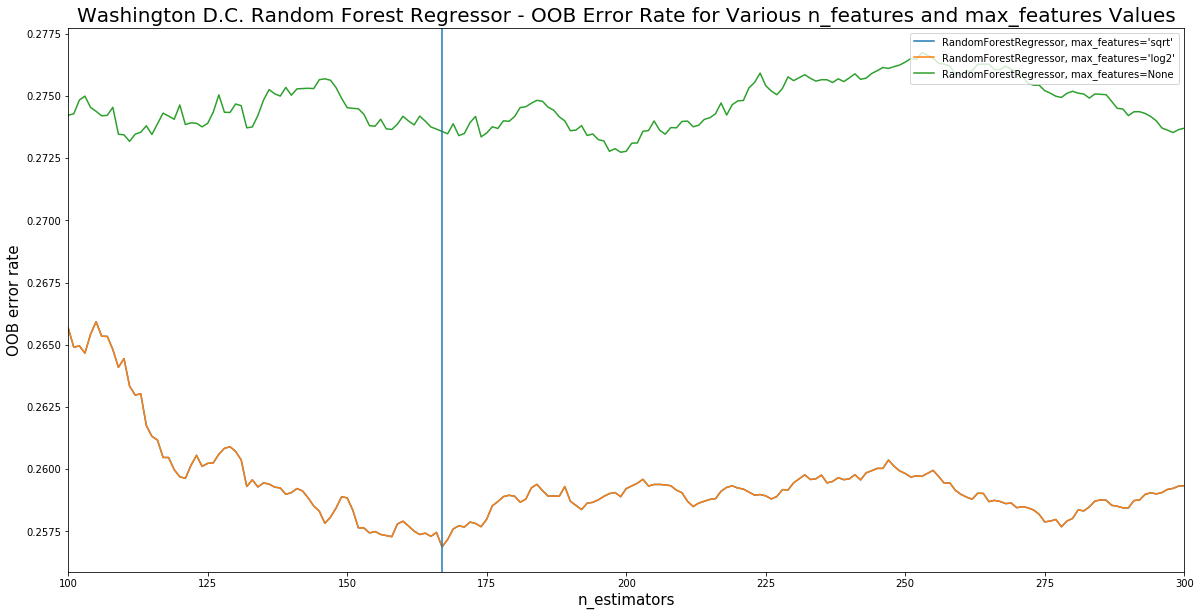

In [84]:
# Code referenced from https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 300
global_min_oob = math.inf

dc_min_n = math.inf

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(dc_train_features, dc_train_prices)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        
        # Save the global minimimum n_estimator value
        if oob_error < global_min_oob:
            global_min_oob = oob_error
            dc_min_n = i

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.rcParams["figure.figsize"] = (20,10)
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize=15)
plt.ylabel("OOB error rate", fontsize=15)
plt.title("Washington D.C. Random Forest Regressor - OOB Error Rate for Various n_features and max_features Values", fontsize=20)
plt.legend(loc="upper right")
plt.axvline(x=dc_min_n)
plt.show()

In [25]:
print("Best n_estimator value for Washington D.C. Random Forest Model:", dc_min_n)

Best n_estimator value for Washington D.C. Random Forest Model: 167


In the above graph, it appears that when *max_feautures = 'sqrt'*, the model's OOB error rate doesn't even appear. This is because after looking deeper into the error rate, the error rate was identical to when the *max_features* = None. This highlights that there appears to be a certain threshold for the *max_features* before the error rate does not change. However, when I set the *max_features* = 'log2', the error rate decreased significantly. The vertical line that I have drawn in the above plot is the *n_features* value where the error rate for the model was the lowest. This model (*max_features = 'log2', n_estimators = 167*) appears to be the best model for the Washington D.C. training data set, and I will use this same process to find the best two parameters to build out the Random Forest regressor for the King County data set:

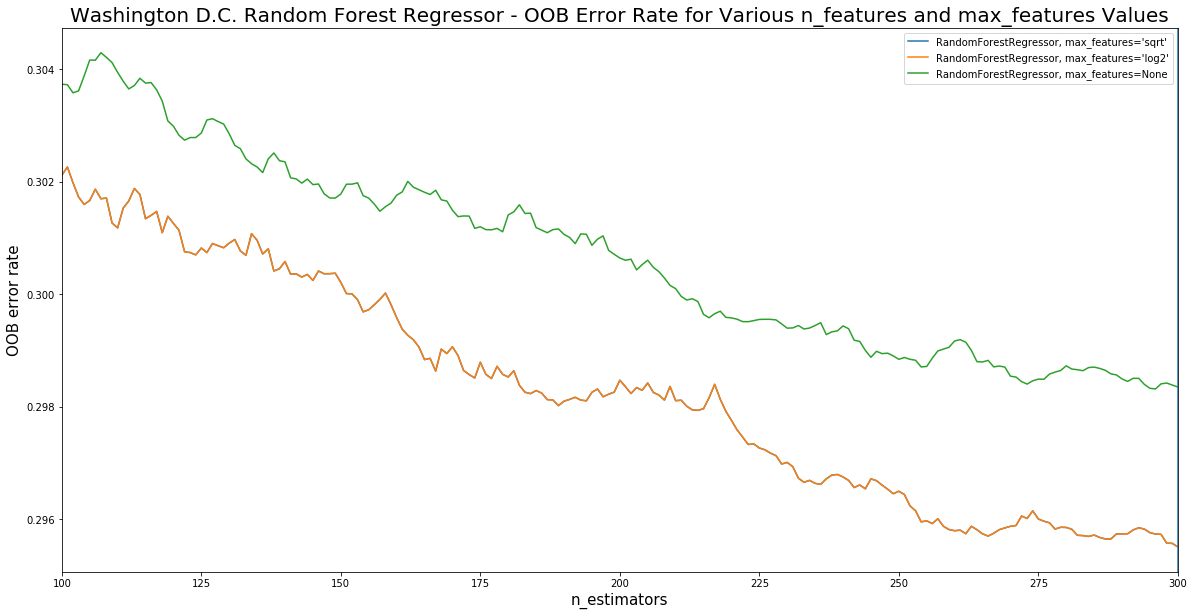

In [85]:
# Code referenced from https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 300
global_min_oob = math.inf

kc_min_n = math.inf

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(kc_train_features, kc_train_prices)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        
        # Save the global minimimum n_estimator value
        if oob_error < global_min_oob:
            global_min_oob = oob_error
            kc_min_n = i

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.rcParams["figure.figsize"] = (20,10)
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize=15)
plt.ylabel("OOB error rate", fontsize=15)
plt.title("Washington D.C. Random Forest Regressor - OOB Error Rate for Various n_features and max_features Values", fontsize=20)
plt.legend(loc="upper right")
plt.axvline(x=kc_min_n)
plt.show()

In [29]:
print("Best n_estimator value for King County Random Forest Model:", kc_min_n)

Best n_estimator value for King County Random Forest Model: 300


Similar to the Washington D.C. random forest regressor, the King County random forest regressor for *max_features = 'sqrt'* doesn't show on the graph. However, the trend for the OOB errors for *max_features = 'log2'* appears to decrease as *n_estimators* increases. The best *n_estimator* for the King County random forest model is 300 when I tested the estimator values ranging from 100 to 300, so I will use this paraameter as the best model for the King County data. Now that I have the parameters for the random forest models, I will compare them to their baseline counterparts and see how well they perform on the test data.

### Define the best Random Forest Models

In [31]:
# Define the best RF models for each data set
dc_RF = RandomForestRegressor(warm_start=True, max_features='log2', oob_score=True, random_state=RANDOM_STATE)
kc_RF =  RandomForestRegressor(warm_start=True, max_features='log2', oob_score=True, random_state=RANDOM_STATE)

# Set parameters
dc_RF.set_params(n_estimators=dc_min_n)
kc_RF.set_params(n_estimators=kc_min_n)

# Fit the models
dc_RF.fit(dc_train_features, dc_train_prices)
kc_RF.fit(kc_train_features, kc_train_prices)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=True, random_state=123, verbose=0, warm_start=True)

## Feature Importance
Random Forest Regressors (RFR) belong to the family on non-parametric models, and do not posses a known closed form. What this means is that I cannot directly look at the model coefficients like I did for the Linear Regression baseline models that took the base form y = a + b<sub>1</sub>x<sub>1</sub> + b<sub>2</sub>x<sub>2</sub> + .... Instead, what I can do is look at the *feature importance* of each housing feature for the random forest models. Scikit-learn's *feature_importances_* model attribute allows me to examine the importance values of each feature. Higher values equates to higher importance. Below is a bar chart of the importances for each random forest model:

### Washinton D.C. Feature Importance Values

In [44]:
pd.DataFrame(zip(dc_train_features.columns, dc_RF.feature_importances_), columns=["Features", "Importance Value"])

,Features,Importance Value
0,bathrooms,0.234591
1,bedrooms,0.070417
2,sqft_living,0.237226
3,sqft_lot,0.099992
4,floors,0.039018
5,condition,0.032830
6,grade,0.108064
7,yr_built,0.095940
8,yr_renovated,0.039032
9,month,0.042889


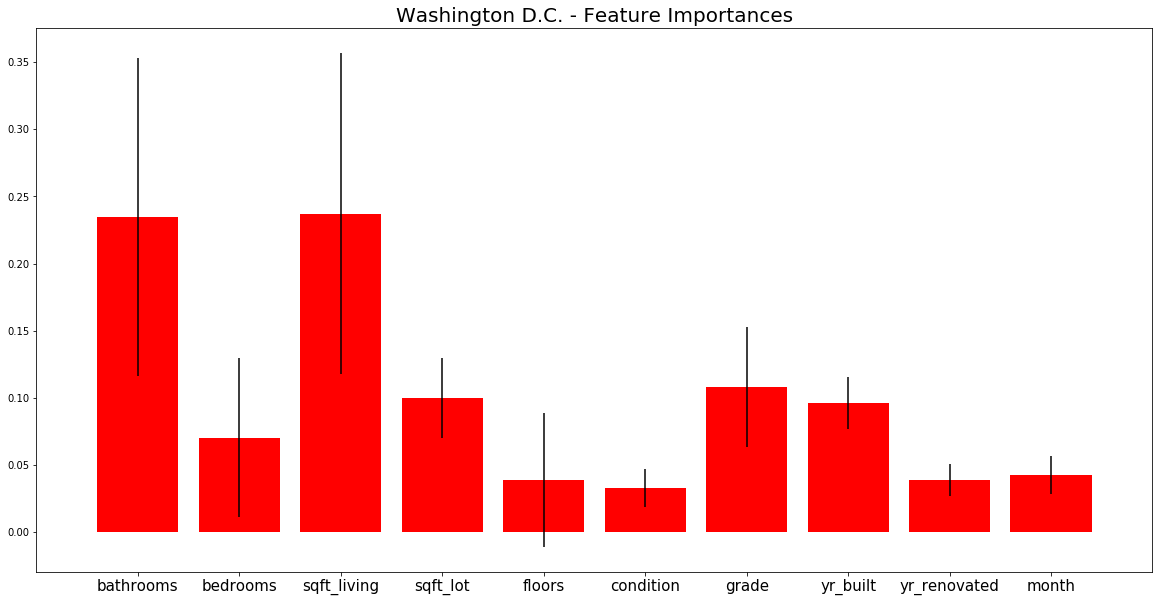

In [65]:
importances = dc_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in dc_RF.estimators_],
             axis=0)
# indices = np.argsort(importances)[::-1]
indices = range(dc_train_features.shape[1])

# Plot the feature importances of the forest
plt.figure()
plt.title("Washington D.C. - Feature Importances", fontsize=20)
plt.bar(range(dc_train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(dc_train_features.shape[1]), dc_train_features.columns, fontsize=15)
plt.xlim([-1, dc_train_features.shape[1]])
plt.show()

### King County Feature Importance Values

In [45]:
pd.DataFrame(zip(kc_train_features.columns, kc_RF.feature_importances_), columns=["Features", "Importance Value"])

,Features,Importance Value
0,bathrooms,0.156772
1,bedrooms,0.037921
2,sqft_living,0.360064
3,sqft_lot,0.088141
4,floors,0.025835
5,condition,0.019109
6,grade,0.150021
7,yr_built,0.105644
8,yr_renovated,0.016768
9,month,0.039724


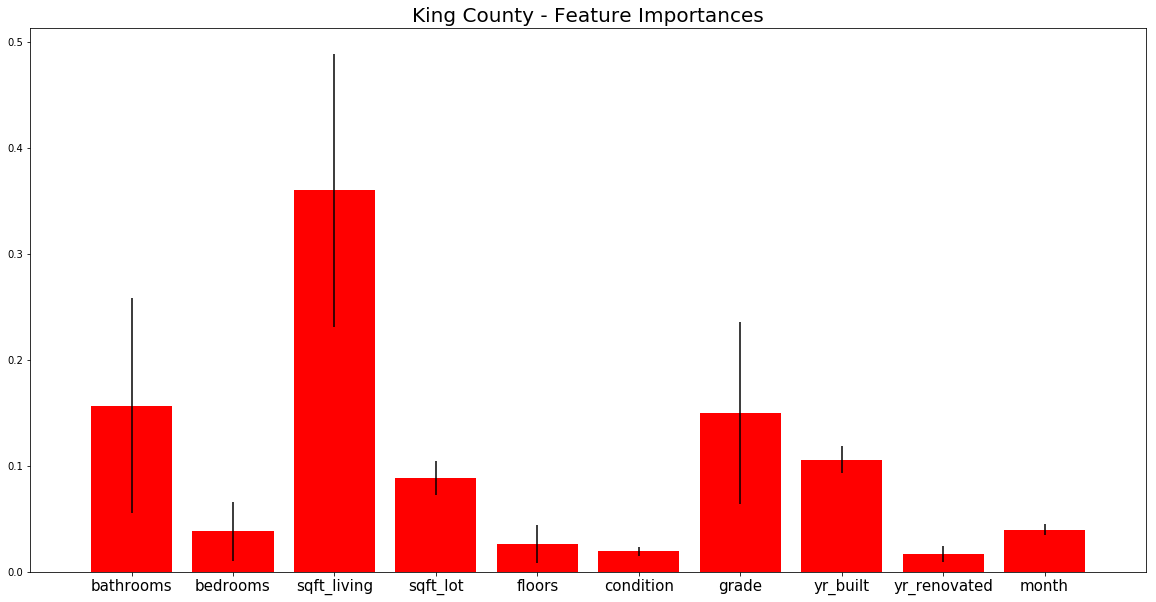

In [64]:
importances = kc_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in kc_RF.estimators_],
             axis=0)
# indices = np.argsort(importances)[::-1]
indices = range(dc_train_features.shape[1])

# Plot the feature importances of the forest
plt.figure()
plt.title("King County - Feature Importances", fontsize=20)
plt.bar(range(kc_train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(kc_train_features.shape[1]), kc_train_features.columns, fontsize=15)
plt.xlim([-1, kc_train_features.shape[1]])
plt.show()

From the above graphs, it is clear that the 'sqft_living' has the highest importance for both the Washington D.C. random forest model and the King County random forest model. However, one distinction that I immediately notice is the 'bathrooms' feature. In the D.C. Random Foreset model, the 'bathrooms' and 'sqft_living' have equal importance. However, the 'bathooms' in the King County model is significantly lower. This highlights a major difference in how the random forest regression algorithm is being affected by different features. Washintgone D.C. appears to place higher importance on the number of bathrooms to determine the price of a house, whereas King County places significantly more importance on the living square feet than any other feature.

### Making the predictions on the test set

In [68]:
# Making the predictions
dc_RF_predictions = dc_RF.predict(dc_test_features)
kc_RF_predictions = kc_RF.predict(kc_test_features)

## Evaluation of the Model
Similar to my baseline model, I will evaluate the Random Forest models using both the R-squared values and Mean Absolute Errors and compare them to their baseline counterparts

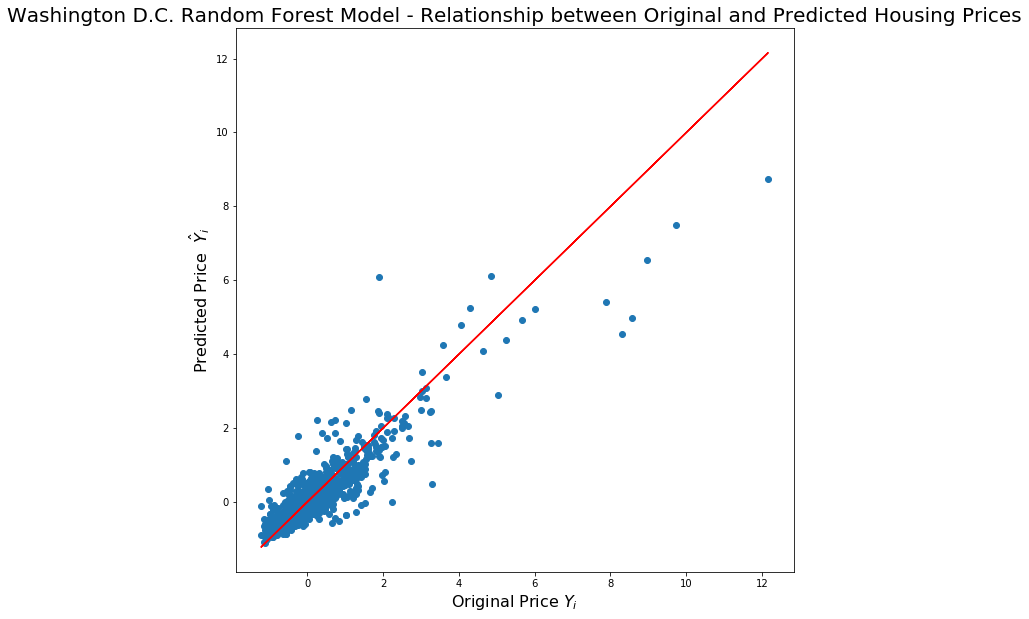

In [70]:
plt.figure(figsize=(10, 10))
plt.scatter(dc_test_prices, dc_RF_predictions)
plt.plot(dc_test_prices, dc_test_prices, 'r-')
plt.xlabel("Original Price $Y_i$", fontsize = 16)
plt.ylabel("Predicted Price  $\hat{Y}_i$", fontsize = 16)
plt.title("Washington D.C. Random Forest Model - Relationship between Original and Predicted Housing Prices", fontsize=20)
plt.show()

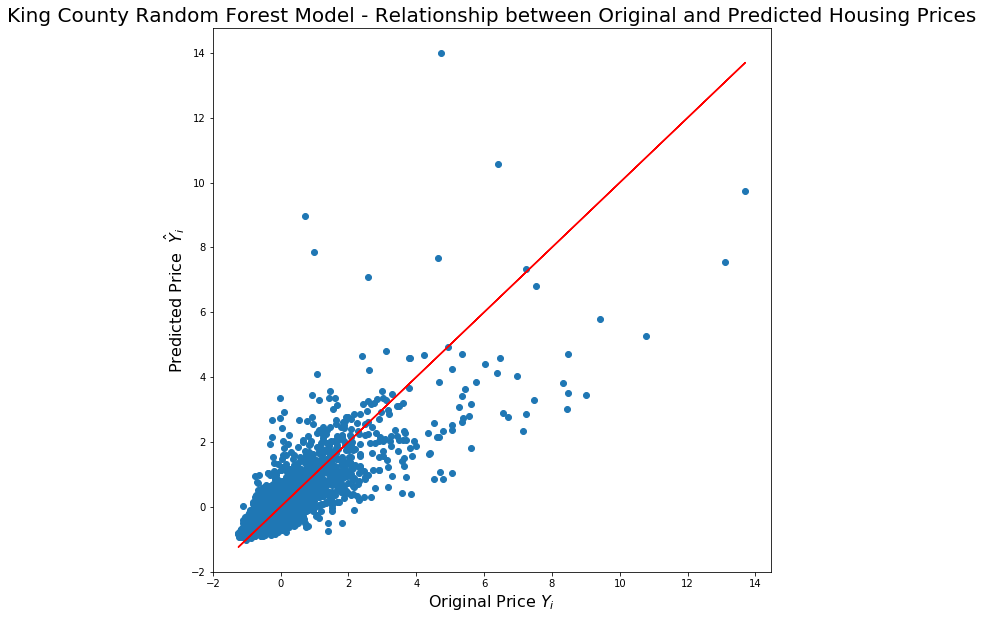

In [71]:
plt.figure(figsize=(10, 10))
plt.scatter(kc_test_prices, kc_RF_predictions)
plt.plot(kc_test_prices, kc_test_prices, 'r-')
plt.xlabel("Original Price $Y_i$", fontsize = 16)
plt.ylabel("Predicted Price  $\hat{Y}_i$", fontsize = 16)
plt.title("King County Random Forest Model - Relationship between Original and Predicted Housing Prices", fontsize=20)
plt.show()

## R-squared values

In [79]:
print("Washington D.C. Random Forest Training R-Squared Score:", dc_RF.score(dc_train_features, dc_train_prices))
print("King County Random Forest Training R-Squared Score:", kc_RF.score(kc_train_features, kc_train_prices))
print("Washington D.C. Random Forest Test R-Squared Score:", dc_RF.score(dc_test_features, dc_test_prices))
print("King County Random Forest Test R-Squared Score:", kc_RF.score(kc_test_features, kc_test_prices))

Washington D.C. Random Forest Training R-Squared Score: 0.963895170964208
King County Random Forest Training R-Squared Score: 0.9593744130898185
Washington D.C. Random Forest Test R-Squared Score: 0.8241541547155612
King County Random Forest Test R-Squared Score: 0.6498936476589086


For the training data, the R-squared values are high. Both are above .95 out of 1, which means that 95% or more of the variance of the prices are accounted for in both models. It is important, however, to also look at how they did for the test data. The Washington D.C. R-squared value went down, but not as significantly as the King County R-squared value. This means that the Washington D.C. Random Forest model generalizes better than the King County model.

Additionally, I want to compare the R-squared values to the Linear Regression models. The baseline R-squared values for the Linear Regression models were 0.5 for Washington D.C. and 0.56 for King County (for the training data). Already, the R-squared values were lower for the Linear Regression models, which supports the fact that the Random Forest models are stronger. Additionally, the Random Forest models generalize better.

## Mean Absolute Error
Similar to the baseline models, I will evaluate the models by the mean absolute errors on the test data.

In [83]:
print("Washington D.C. Test Mean Absolute Error:", meanabs(dc_test_prices, dc_RF_predictions))
print("King County Test Mean Absolute Error:", meanabs(kc_test_prices, kc_RF_predictions))

Washington D.C. Test Mean Absolute Error: 0.24543597359940245
King County Test Mean Absolute Error: 0.360429926738529


Similar to the R-squared values for the Random Forest models, the mean absolute errors are also significantly lower for the test data when using the Random Forest models. For the Washington D.C. Linear Regression model, the MAE was 0.42, and for the King County model the MAE was 0.45. For both data sets, the MAE dropped when using the Random Forest Regressor, making the predictions more accurate and reliable.